<H1><center>Capstone Project</center></H1>
<img src="https://upload.wikimedia.org/wikipedia/commons/d/dc/Foursquare_logo.svg" align="center" width="100">
<H2><center>Choosing a Restaurant Category for a New Business</center></H2>
<H3><center>A Business Intelligence Exercise</center></H3>

_______

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology - Prediction Task](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

_____

## Introduction: Business Problem <a name="introduction"></a>

On this project, the Data Scientist is working with **Company R**, a family business with over 40 years experience in brick and mortar souvenir shops. The company wishes to diversify it's business and has recently acquired a new space close to one of Lisbon's main landmarks. The problem is that this is a new market for **Company R** and management is unsure as to what kind of venue to invest on.
**Company R** learned about Foursquare and started looking into the most common venues in the country, but the data was too much to make sense of just by browsing Foursquare's city guide. However, determined to make an informed decision, management decided to hire Business Intelligence Consultant that could analyze the data and present some options.

## Data <a name="data"></a>

In this project, Foursquare's API will be the only source of data.

The reasoning behind this project is: 
* Company R's best bet is to invest in a type of venue that will attract the maximum number of customers and yield the highest ratings possible;
* The new venue should be unique in it's Category in the area where it will open;
* The new business must fit Company R's culture;
* The new business should fit the area where it will open.

With this in mind, the data will be used as follows:

First step - Categories to be considered:
* Retrieve from the Foursquare API the top 50 Landmarks in Portugal, similar to the Landmark next to which the new venue will open;
* Fetch the top 5 venues in proximity to those Landmarks and make a rough analysis of which Categories are more numerous.

Second step - Ranking:
* Assuming that the number of photos is proportional to the number of visitors to each venue, a calculation will be made of a popularity score, which is the product of rating and number of photos; 
* With this new score, categories will be grouped and sorted based on their average popularity score.

Third step - The Gap:
* The list of venues close to the new business's location will be retrieved and sorted by categories and their respective popularity score;
* Finally, from the top Categories identified in the second step, Company R will be able to choose which Category to invest on, given that the Category picked is not present in the new location. 

<h4>Importing libraries and setting things up for this notebook. Everything was added as needed.</h4>

In [1]:
import pandas as pd
import numpy as np
import json
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
%matplotlib inline 
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import pydotplus

from IPython.display import Image  

import seaborn as sns

from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
#from geopy.geocoders import Nominatim 
print('All systems go!')

All systems go!


In [2]:
# install wordcloud
!conda install -c conda-forge wordcloud==1.4.1 --yes

# import package and its set of stopwords
from wordcloud import WordCloud, STOPWORDS

print ('Wordcloud is installed and imported!')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.2

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - wordcloud==1.4.1


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    scikit-learn-0.20.1        |   py36h22eb022_0         5.7 MB
    liblapack-3.8.0            |      11_openblas          10 KB  conda-forge
    numpy-1.18.1               |   py36h95a1406_0         5.2 MB  conda-forge
    liblapacke-3.8.0           |      11_openblas          10 KB  conda-forge
    libopenblas-0.3.6          |       h5a2b251_2         7.7 MB
    scipy-1.4.1                |   py36h921218d_0        18.9 MB  conda-fo

In [3]:
!conda install -c conda-forge pydotplus -y
!conda install -c conda-forge python-graphviz -y
print('All Condas GOOO!!')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.2

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.2

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - python-graphviz


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    python-graphviz-0.13.2     |             py_0          18 KB  conda-forge

The following NEW packages will be INSTALLED:

    python-graphviz: 0.13.2-py_0 conda-forge


python-graphviz-0.13 | 18 KB     | ##################################### | 100% 
Preparing

<h4>Saving the Foursquare API credentials right away</h4>

In [4]:
CLIENT_ID = 'ABXB2WL4QQYWX4AE3SNRZ0SO114YA4KEA5A5QD14JG2HYVXM' # your Foursquare ID
CLIENT_SECRET = '1XLZ5NEWN4RH034HM2W3WVKWPRBRLV34WW50O43VLALDKXP5' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: ABXB2WL4QQYWX4AE3SNRZ0SO114YA4KEA5A5QD14JG2HYVXM
CLIENT_SECRET:1XLZ5NEWN4RH034HM2W3WVKWPRBRLV34WW50O43VLALDKXP5


_____

<h2>1. Defining relevant Categories</h2>
<h4>1.1 Retrieving 50 Monuments/Landmarks in the country</h4>
Using the Foursquare */venues/explore/* **endpoint** to retrieve venues with the tag *Landmark* in *Portugal*.

In [5]:
url = 'https://api.foursquare.com/v2/venues/explore/'

params = dict(
  client_id=CLIENT_ID,
  client_secret=CLIENT_SECRET,
  v='20180323',
  near='Portugal',
  query='landmark',
  limit=50
)
resp = requests.get(url=url, params=params)
data = json.loads(resp.text)

In [6]:
venues = data['response']['groups'][0]['items']
landmarks = json_normalize(venues)

In [7]:
landmarks.shape

(50, 32)

<br></br>
<h4>1.2 Retrieving details for the top 50 Monuments/Landmarks</h4>
The *venues* **endpoint** is used to retrieve details, in which the coordinates of each landmark are included. These will later be used to retrieve nearby food venues.

**Note** The cells below were run only once, and the data was saved on a csv for faster and consistent use, therefore the code is presented for reference and can be used in case the CSV file is not present.

In [8]:
#i=0
#for n in landmarks['venue.id']:
#    VENUE_ID = n
#    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
#    VENUE_ID,    
#    CLIENT_ID, 
#    CLIENT_SECRET, 
#    VERSION)
#    rating = requests.get(url).json()['response']['venue']['rating']
#    photo = requests.get(url).json()['response']['venue']['photos']['count']
#    landmarks.loc[i,['Rating']] = rating
#    landmarks.loc[i,['Photos']] = photo
#    i = i+1

In [9]:
#landmarks.head()

In [10]:
# filter columns
#filtered_columns = ['venue.id','venue.name', 'venue.location.lat', 'venue.location.lng', 'Rating', 'Photos']
#landmarks =landmarks.loc[:, filtered_columns]
# clean columns
#landmarks.columns = [col.split(".")[-1] for col in landmarks.columns]
#landmarks.head()

In [11]:
#landmarks.sort_values(by=['Photos', 'Rating'], ascending=False)

In [12]:
#landmarks.head()
#landmarks.to_csv(r'landmarks2.csv', index = False, header=True) 

# After I ran the lines above once, I started using the CSV created for later tweaking of the project:
landmarks = pd.read_csv('landmarks.csv')

<br></br>
<h4>1.3 Retrieve top 5 food Venues within 250m of each Landmarks's location</h4>

Defining the function, radius and number of **venues** per **Landmark** to be extracted and retrieving the **food venues** list from the surrounding area of each **landmark**, by once again using the *venues* **endpoint**.

**Note** The cells below were run only once, and the data was saved on a csv for faster and consistent use, therefore the code is presented for reference and can be used in case the CSV file is not present.

In [13]:
# Retrieve 5 food places around landmarks
#LIMIT = 5
#radius = 250
#query = 'food'

# function that extracts nearby venues
#def getNearbyVenues(names, latitudes, longitudes):
    
#    venues_list=[]
#    for name, lat, lng in zip(names, latitudes, longitudes):
        
#        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&query={}'.format(
#            CLIENT_ID, 
#            CLIENT_SECRET, 
#            VERSION, 
#            lat, 
#            lng, 
#            radius, 
#            LIMIT,
#            query)
            
        # make the GET request
#        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
#        venues_list.append([(
#            name, 
#            lat, 
#            lng, 
#            v['venue']['name'],  
#            v['venue']['categories'][0]['name'],
#            v['venue']['id']) for v in results])

#    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
#    nearby_venues.columns = ['Landmark', 
#                  'Venue', 
#                  'Venue Latitude', 
#                  'Venue Longitude', 
#                  'Venue Category',
#                  'Venue ID']
    
#    return(nearby_venues)

In [14]:
#lm_venues = getNearbyVenues(names=landmarks['name'],
#                                   latitudes=landmarks['lat'],
#                                   longitudes=landmarks['lng']
#                                  )

In [15]:
#lm_venues.head()

<h4>1.3.1 Retrieve Rating and Photos Count for these venues</h4>

In [16]:
#lm_venues['Rating'] = lm_venues.apply(lambda _: '', axis=1)
#lm_venues['Photos'] = lm_venues.apply(lambda _: '', axis=1)
#i=0
#for n in lm_venues['Venue ID']:
#    VENUE_ID = n
#    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
#    VENUE_ID,    
#    CLIENT_ID, 
#    CLIENT_SECRET, 
#    VERSION)
#    try:
#        rating = requests.get(url).json()['response']['venue']['rating']
#        photo = requests.get(url).json()['response']['venue']['photos']['count']
#        lm_venues.loc[i,['Rating']] = rating
#        lm_venues.loc[i,['Photos']] = photo
#    except (KeyError):
#        rating = 0
#        photo = 0
#    i = i+1
#lm_venues = lm_venues.sort_values(by=['Photos', 'Rating'], ascending=False)
#lm_venues.head()
#lm_venues.to_csv(r'lm_venues2.csv', index = False, header=True)

In [17]:
# After I ran the lines above once, I started using the CSV created for later tweaking of the project:
lm_venues = pd.read_csv('lm_venues.csv')
lm_venues = lm_venues.dropna()
lm_venues

,Landmark,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue ID,Rating,Photos
0,Torre de Belém,Confeitaria Nacional,38.691951,-9.213905,Café,57dec237498e779b838d523d,8.3,27.0
1,Torre de Belém,Lisboa Vista do Tejo - Cais da Princesa,38.691946,-9.213940,Café,4db355b9fa8c350240cc1404,7.5,28.0
2,Torre de Belém,Café do Forte,38.691976,-9.216876,Sandwich Place,4c5da75e6147be9a86a69209,6.8,94.0
5,Padrão dos Descobrimentos,Espelho de Agua,38.693727,-9.207113,Gastropub,5411828c498ea650de0a09d9,8.2,28.0
6,Padrão dos Descobrimentos,Espaço Espelho d'Água,38.693818,-9.207119,Diner,547ddfaf498ecc35f9db4392,8.2,59.0
...,...,...,...,...,...,...,...,...
181,Estátua D. João I,Floresta das Escadinhas,38.712703,-9.136417,Portuguese Restaurant,4f7d9a24e4b0fe094154be75,8.7,14.0
182,Avião e Monumento 1ª Travessia do Atlântico,Confeitaria Nacional,38.691951,-9.213905,Café,57dec237498e779b838d523d,8.3,27.0
183,Avião e Monumento 1ª Travessia do Atlântico,Lisboa Vista do Tejo - Cais da Princesa,38.691946,-9.213940,Café,4db355b9fa8c350240cc1404,7.5,28.0
184,Avião e Monumento 1ª Travessia do Atlântico,Café do Forte,38.691976,-9.216876,Sandwich Place,4c5da75e6147be9a86a69209,6.8,94.0


**All the data required for this analysis is now available.**

____

## Methodology <a name="methodology"></a>
The aim of this project is to establish what kind of food venue would be a best bet for a given location, in the vicinity of Castelo de São Jorge. The following assumptions were made:

- The number of photos taken and published at a venue, correlate with the amount of visiting customers;
- The best choice of a venue type for one landmark is a balance of selecting one that rates high in popularity in similar landmarks but has low competition on this particular landmark;
- **Company R**'s culture must be taken into account when selecting venue type, otherwise it might fail for not being in sync with current line of business, values and team.

_____

## Analysis <a name="analysis"></a>
Visualization tools are a great way to get a grasp of our data. The following steps will promote a better understanding of the business ecosystem in proximity to national landmarks.

<h4>1.4 A wordcloud is an appealing visual way of showing how prevalent each category is in the general picture</h4>

In [18]:
stopwords = set(STOPWORDS)
stopwords.add('object')
stopwords.add('dtype')
stopwords.add('name')
stopwords.add('length')
stopwords.add('place')
stopwords.add('Category')

In [19]:
lm_venues = lm_venues.rename(columns={"Venue Latitude": "Lat", "Venue Longitude": "Lng", "Venue Category": "Category", "Venue ID": "ID"})
lm_venues.head(0)

,Landmark,Venue,Lat,Lng,Category,ID,Rating,Photos


In [20]:
# instantiate a word cloud object
venue_wc = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords
)
lista = str(lm_venues['Category'])
# generate the word cloud
venue_wc.generate(lista)

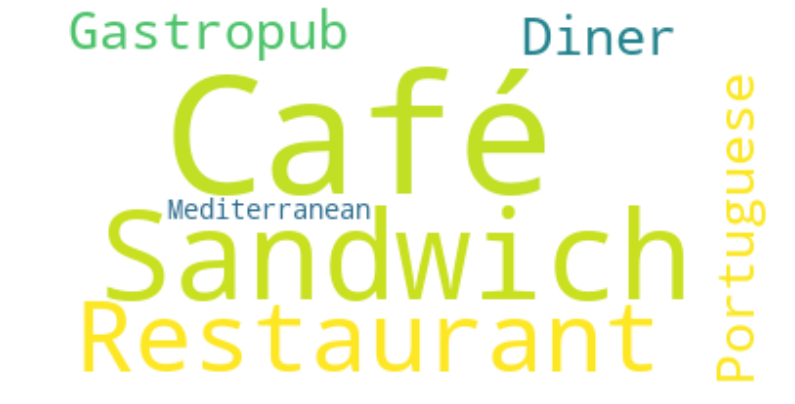

In [21]:
fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height

# display the cloud
plt.imshow(venue_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

The wordcloud is a great way to see what kind of venues are more prevalent. From this, two strategies might arise: 


- **Company R** might choose to bet on a low risk and low differentiation strategy and pick a common category with a predictable rate of return, or;
- **Company R** could bet on a less common category with a higher expected return.

In order to make an informed decision, **Company R** needs a quantified analysis of how popular each category is, assuming that popularity can be quantified by multiplying an indicator of number of customers (photos published) by the rating of the venues published within that category.

In [22]:
# Creating the Photos and Ratings dataframe
venue_hist = lm_venues.groupby('Category').mean()
venue_hist = venue_hist.sort_values('Rating', ascending=False)
venue_hist

,Lat,Lng,Rating,Photos
Category,,,,
Vegetarian / Vegan Restaurant,41.446780,-8.292146,9.000000,56.000000
Empanada Restaurant,38.713572,-9.135550,8.900000,17.000000
American Restaurant,38.716657,-9.141767,8.900000,2402.000000
Tapas Restaurant,40.659157,-8.718162,8.840000,86.200000
Food Truck,38.712871,-9.134241,8.800000,23.000000
Argentinian Restaurant,41.142553,-8.616698,8.700000,16.000000
Breakfast Spot,41.147545,-8.609962,8.650000,77.000000
Bistro,40.208814,-8.428307,8.500000,36.000000
Indian Restaurant,38.709485,-9.149954,8.450000,23.833333


In [23]:
venue_histr = venue_hist['Rating']
venue_histp = venue_hist['Photos']

<h4>1.5 Bar charts are also a great way of visualizing data with the advantage of quantifying it, as shown in the plots below</h4>

**NOTE** - On the following plots, one outlier was identified and removed from the dataset: THE HARD ROCK CAFE, for it's brand and marketing capacity is outside the scope of this comparison as **Company R** will be competing with equally sized, small to medium, businesses.

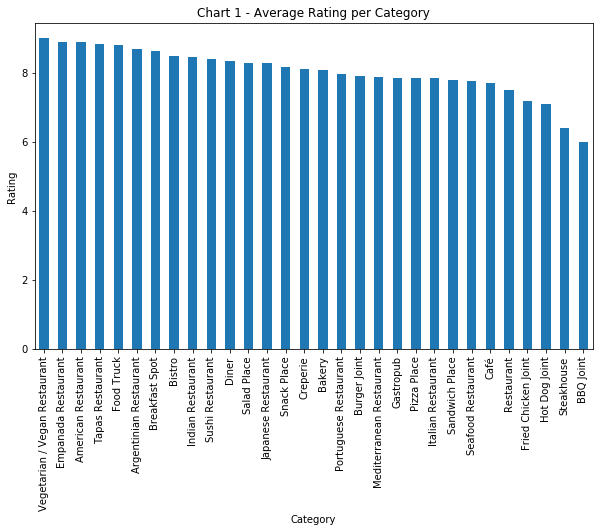

In [24]:
# step 2: plot data
venue_histr.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Category') # add to x-label to the plot
plt.ylabel('Rating') # add y-label to the plot
plt.title('Chart 1 - Average Rating per Category') # add title to the plot

plt.show()

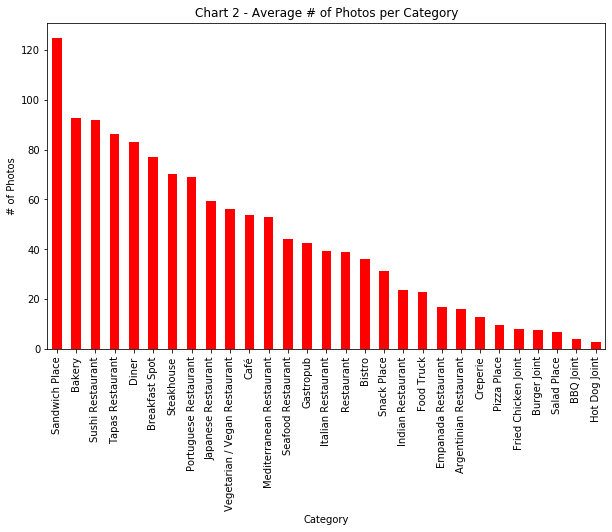

In [25]:
# step 2: plot data
venue_histp.pop('American Restaurant') 
venue_histp = venue_histp.sort_values(ascending=False)
venue_histp.plot(kind='bar', figsize=(10, 6), color='red')

plt.xlabel('Category') # add to x-label to the plot
plt.ylabel('# of Photos') # add y-label to the plot
plt.title('Chart 2 - Average # of Photos per Category') # add title to the plot

plt.show()

In [26]:
#Run Popularity contest
venue_pop = venue_hist.drop(columns = ['Lat', 'Lng'])
venue_pop = venue_pop.groupby('Category').mean()
venue_pop['Pop'] = venue_hist['Rating'] * venue_hist['Photos']
venue_pop = venue_pop.dropna()
venue_pop=venue_pop.sort_values('Pop', ascending=False)

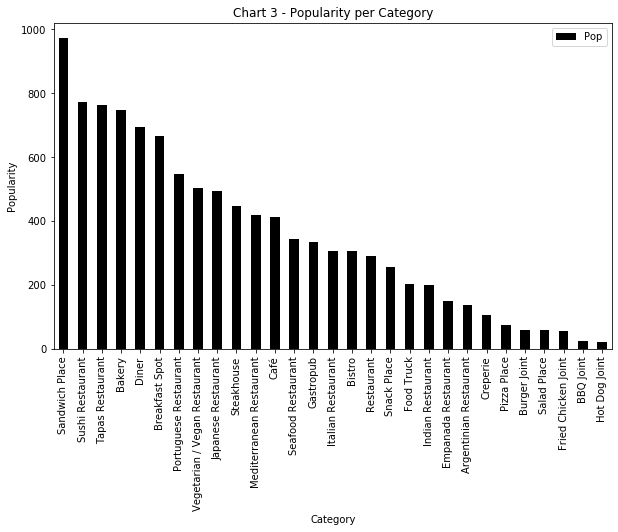

In [28]:
# step 2: plot data
#venue_histp.pop('American Restaurant')
venue_pop=venue_pop.drop(columns = ['Rating','Photos'])
venue_pop.plot(kind='bar', figsize=(10, 6), color='black')

plt.xlabel('Category') # add to x-label to the plot
plt.ylabel('Popularity') # add y-label to the plot
plt.title('Chart 3 - Popularity per Category') # add title to the plot

plt.show()

_____

<h2>3. The GAP</h2>
It is now time to take a deeper look at the business ecosystem around the location where **Company R** wishes to start its new venture. The goal now is to identify the existing venue categories and their popularity.

This might take **Company R** down one of two paths:
- Either there is a clear gap (a blue ocean) in the ecosystem, presenting **Company R** with the opportunity to implement a strategy of differentiation by betting on an non-existing category that has shown to be highly popular in the vicinity of similar landmarks, or;
- The ecosystem is saturated and **Company R** further analysis is needed to assess which category has a higher rate of return based on its frequency in the area versus its expected popularity.

In [29]:
# Now we look deeper at the location we have available
focusarea = lm_venues.loc[lm_venues['Landmark']=='Castelo de São Jorge']

In [30]:
focusarea.head(10)

,Landmark,Venue,Lat,Lng,Category,ID,Rating,Photos
34,Castelo de São Jorge,Wine With a View,38.712871,-9.134241,Food Truck,55149655498eb8bdba6f215c,8.8,23.0
35,Castelo de São Jorge,Miss Can Petiscaria,38.711952,-9.131216,Portuguese Restaurant,57486374cd10843a7161a25d,8.7,21.0
36,Castelo de São Jorge,paladarium,38.712130,-9.134966,Salad Place,57c87e09498e5f202e8a65ce,8.3,7.0
37,Castelo de São Jorge,Chapito à Mesa,38.711403,-9.133939,Portuguese Restaurant,5804f03c38fa104ef10e981b,8.3,67.0
38,Castelo de São Jorge,O Eurico,38.712664,-9.135528,Portuguese Restaurant,4dfc9a48483b96a3aaa64550,8.4,43.0


In [31]:
#Run Popularity contest
focus_pop = focusarea.drop(columns = ['Lat', 'Lng'])
focus_pop.set_index('Landmark', drop=True)
focus_pop['Pop'] = focusarea['Rating'] * focusarea['Photos']
focus_pop = focus_pop.dropna()
focus_pop = focus_pop.groupby('Category').mean()
focus_pop=focus_pop.sort_values('Pop', ascending=False)
focus_pop=focus_pop.drop(columns = ['Rating','Photos'])
focus_pop.head()

,Pop
Category,
Portuguese Restaurant,366.666667
Food Truck,202.400000
Salad Place,58.100000


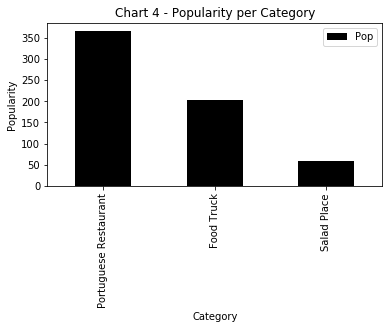

In [32]:
# step 2: plot data
#venue_histp.pop('American Restaurant')
focus_pop.plot(kind='bar', figsize=(6, 3), color='black')

plt.xlabel('Category') # add to x-label to the plot
plt.ylabel('Popularity') # add y-label to the plot
plt.title('Chart 4 - Popularity per Category') # add title to the plot

plt.show()

The top Categories that are non-existing in this area are: **Sandwich Place; Sushi Bar; Tapas Bar**
Considering the core business and culture of the customer's company, the Sushi Bar is not a good fit, so we're betting on a Portuguese Style Tapas Bar that has Sandwiches on the Menu.

**WOW!** This is the perfect outcome! The business ecosystem around this landmark is a blue ocean! It shows very little diversity and the existing businesses are in categories that are actually low in popularity when compared to similar landmarks! It is now up to **Company R** to choose from the top Categories listed in *Chart 3* the category that best fits its corporate identity.

_____

## Results and Discussion <a name="results"></a>

The analysis shows that within the vicinity of historical landmarks in continental Portugal, **Sandwich Places, Sushi and Tapas Restaurants, Bakeries and Diners** are the most popular places. **Vegetarian Restaurant** are highly rated but they're a nouvelle business with less clients, but this might change in the future so it might be worth it to keep an eye out for this business segment.

By zooming in on the area where **Company R** intends to open its new venture, it becomes clear that the business ecosystem is nothing like the Country-wide picture, with businesses low in differentiation and none of them acting within the categories previously listed as high in popularity.

_____

## Conclusion <a name="conclusion"></a>

**Company R** has a great opportunity on its hands as the results of this analysis have yielded the best case scenario: a blue ocean business ecosystem within the vicinity of one of the most popular landmarks in the country. Furthermore, the company has a competitive advantage for having access to high level Business Intelligence, currently ignored by even the top players in this market.

Out of the highest ranking in popularity categories, the *Sushi Restaurant* is possibly the only unfitting option, as the company's corporate identity has a strong tradition of working with Portuguese gifts, crafts and souvenirs. 

Therefore, the path is clear. The only question now is how will **Company R** adequately market and position its new business of *Portuguese Tapas and Sandwiches*.